# Iris Dataset Classification with a Neural Network

### 1. Importing Libraries

In [164]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score

We import essential libraries for data manipulation (Pandas, Numpy), visualization (Matplotlib, Seaborn), and building our neural network using PyTorch.

### 2. Loading and Preparing the Dataset

In [165]:
iris = load_iris(as_frame=True)
df = iris.data.copy()
df['species_n'] = [iris.target_names[label] for label in iris.target]
df.head()


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species_n
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [166]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   species_n          150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [167]:
df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


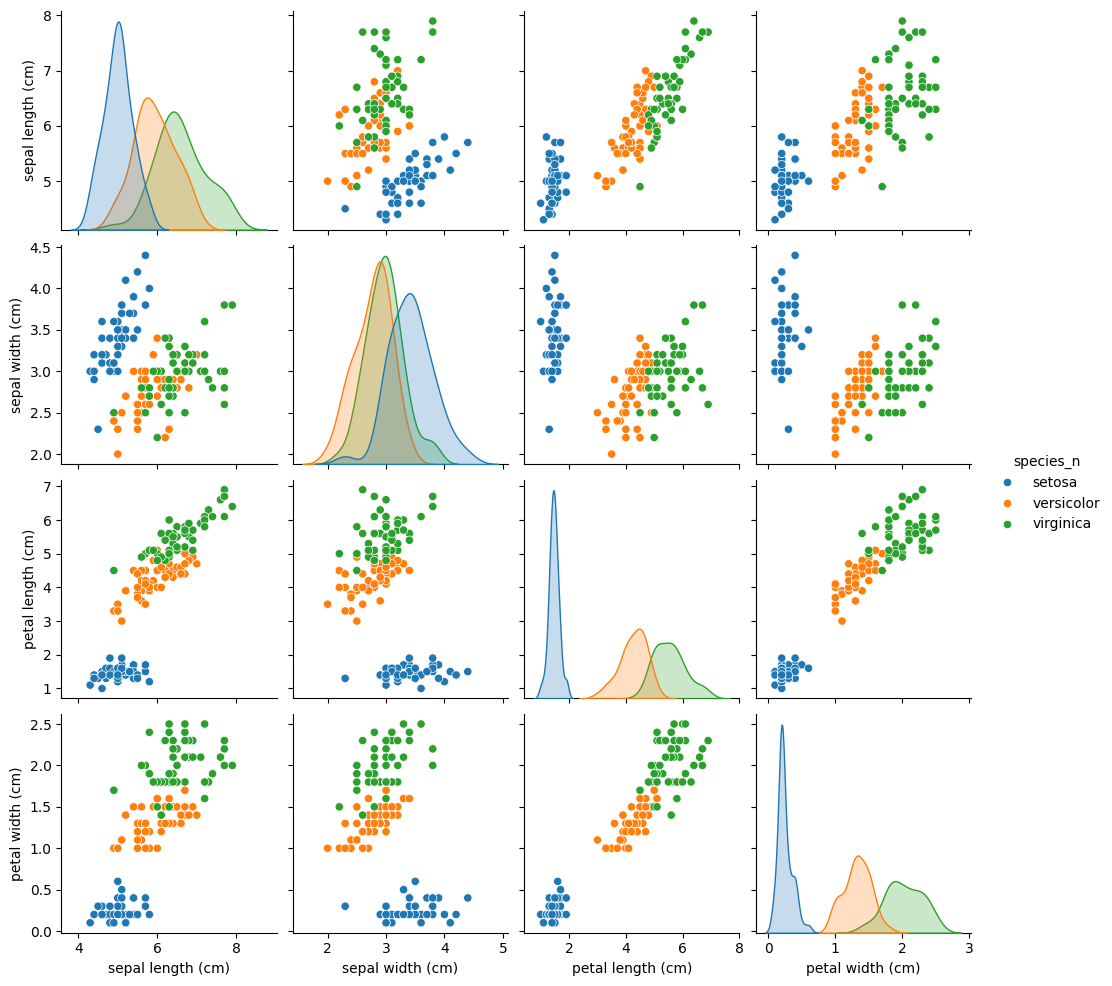

In [168]:
sns.pairplot(df, hue='species_n')

<Axes: xlabel='species_n', ylabel='count'>

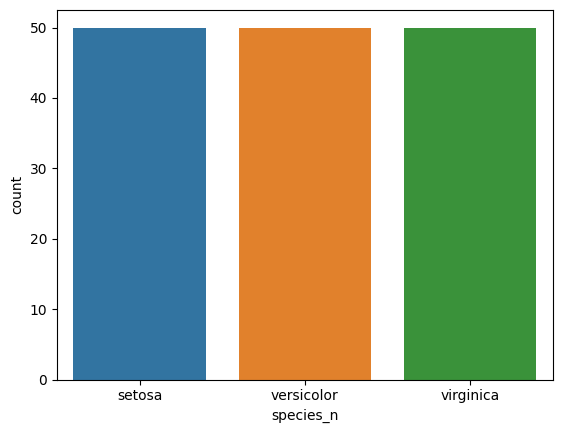

In [169]:
sns.countplot(x=df.species_n, hue=df.species_n)

After loading the **Iris dataset**, split it into training, validation, and test sets, and standardize the features for better model performance.


In [170]:
# Splitting the data
X = iris.data
Y = iris.target
X_train, X_tv, y_train, y_tv = train_test_split(X, Y, test_size=0.2, random_state=42)

In [171]:
# Standardizing
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

X_valid, X_test, y_valid, y_test = train_test_split(X_tv, y_tv, test_size=0.5, random_state=42)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

### 3. Setting Up Device Configuration

In [ ]:
# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#### Convert data to tensors

We prepare the data by converting it to PyTorch tensors and sending it to the GPU if available.


In [173]:
# Convert data to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.int64).to(device)
X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32).to(device)
y_valid_tensor = torch.tensor(y_valid.to_numpy(), dtype=torch.int64).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)


We define a custom **Artificial Neural Network (ANN)** class with two hidden layers and ReLU activations. We do not apply Softmax as **CrossEntropyLoss** handles it internally.


In [174]:
# Neural Network Model
class ANN(nn.Module):
    def __init__(self, in_features, hidden1, hidden2, out_features):
        super().__init__()
        self.layer1 = nn.Linear(in_features, hidden1)
        self.layer2 = nn.Linear(hidden1, hidden2)
        self.layer3 = nn.Linear(hidden2, out_features)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.layer3(x)  # No softmax here since CrossEntropyLoss applies it internally
        return x


We use **CrossEntropyLoss** for multi-class classification and the **Adam optimizer** with a learning rate of `0.01`.

In [188]:
in_features = X_train.shape[1]
num_classes = len(set(Y))

model = ANN(in_features, 8, 8, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

We train the model for **1000 epochs**, tracking both training and validation loss and accuracy. The model is evaluated on the validation set after each epoch.


In [189]:
# Training loop
num_epochs = 1000

for epoch in range(num_epochs):
    model.train()

    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Calculate accuracy
    _, predicted_labels = torch.max(outputs, 1)
    correct_predictions = (predicted_labels == y_train_tensor).sum().item()
    acc = correct_predictions / len(y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Validation phase
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_valid_tensor)
        val_loss = criterion(val_outputs, y_valid_tensor)
        _, val_predicted = torch.max(val_outputs, 1)
        val_acc = accuracy_score(y_valid_tensor.cpu().numpy(), val_predicted.cpu().numpy())

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {acc:.4f}, Val Loss: {val_loss.item():.4f}, Val Accuracy: {val_acc:.4f}')

Epoch [10/1000], Loss: 0.9293, Accuracy: 0.6417, Val Loss: 0.9265, Val Accuracy: 0.5333
Epoch [20/1000], Loss: 0.6249, Accuracy: 0.7833, Val Loss: 0.5788, Val Accuracy: 0.9333
Epoch [30/1000], Loss: 0.4657, Accuracy: 0.8000, Val Loss: 0.4115, Val Accuracy: 0.8667
Epoch [40/1000], Loss: 0.3882, Accuracy: 0.8833, Val Loss: 0.3373, Val Accuracy: 0.9333
Epoch [50/1000], Loss: 0.3115, Accuracy: 0.8750, Val Loss: 0.2395, Val Accuracy: 1.0000
Epoch [60/1000], Loss: 0.2366, Accuracy: 0.9250, Val Loss: 0.1564, Val Accuracy: 1.0000
Epoch [70/1000], Loss: 0.1691, Accuracy: 0.9583, Val Loss: 0.1079, Val Accuracy: 1.0000
Epoch [80/1000], Loss: 0.1150, Accuracy: 0.9667, Val Loss: 0.0744, Val Accuracy: 1.0000
Epoch [90/1000], Loss: 0.0854, Accuracy: 0.9667, Val Loss: 0.0476, Val Accuracy: 1.0000
Epoch [100/1000], Loss: 0.0721, Accuracy: 0.9667, Val Loss: 0.0338, Val Accuracy: 1.0000
Epoch [110/1000], Loss: 0.0637, Accuracy: 0.9667, Val Loss: 0.0293, Val Accuracy: 1.0000
Epoch [120/1000], Loss: 0.0582

We evaluate the model on the **test set**, calculate the final loss and accuracy, and print a **classification report** showing precision, recall, and F1-score for each class.


In [191]:
model.eval()
with torch.inference_mode():
    outputs = model(X_test_tensor)
    probabilities = torch.softmax(outputs, dim=1)  # Softmax for final probabilities
    _, predicted = torch.max(probabilities, 1)

    accuracy = accuracy_score(y_test, predicted.cpu().numpy())

    loss = criterion(outputs, torch.tensor(y_test.to_numpy(), dtype=torch.int64).to(device))

    print(f"Loss: {loss.item():.4f}", f"Accuracy: {accuracy:.4f}")

    print(classification_report(y_test, predicted.cpu().numpy(), target_names=iris.target_names))

    precision = precision_score(y_test, predicted.cpu().numpy(), average=None)
    recall = recall_score(y_test, predicted.cpu().numpy(), average=None)
    f1 = f1_score(y_test, predicted.cpu().numpy(), average=None)

    for i, class_name in enumerate(iris.target_names):
        print(f"{class_name} - Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1-Score: {f1[i]:.4f}")


Loss: 0.6591 Accuracy: 0.9333
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00         5
  versicolor       0.86      1.00      0.92         6
   virginica       1.00      0.75      0.86         4

    accuracy                           0.93        15
   macro avg       0.95      0.92      0.93        15
weighted avg       0.94      0.93      0.93        15

setosa - Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000
versicolor - Precision: 0.8571, Recall: 1.0000, F1-Score: 0.9231
virginica - Precision: 1.0000, Recall: 0.7500, F1-Score: 0.8571
